# Diferenciación automática: Parte 2

* Daniel Martínez (@danmarurr)
* Fernanda Pérez (@FernandaPerez)
   

### NOTA

Este notebook se iniciará en la clase y **debe** hacerse en equipo, con los *mismos miembros* que participaron en la "Tarea4.ipynb". La resolución completa de los ejercicios debe ser enviada como "Tarea5.ipynb".

## Funciones elementales

Lo que se logró en la clase pasada fue, esencialmente, tener una manera de obtener primeras
derivadas para cualquier función racional, esto es, cocientes de polinomios en una variable.

El siguiente paso es incluir más funciones a fin de ampliar la aplicabilidad de lo hecho la vez pasada, en particular a las funciones elementales: $\exp$, $\log$, etc.

La extensión a estas funciones es elemental, y así por ejemplo tenemos:

\begin{eqnarray}
\exp[\vec{f}(x_0)] &=& \big( \exp(f_0),\, f'_0\exp(f_0) \,\big),\\
\log[\vec{f}(x_0)] &=& \big( \log(f_0),\, \frac{f'_0}{f_0} \,\big),\\
\sin[\vec{f}(x_0)] &=& \big( \sin(f_0),\, f'_0\cos(f_0) \,\big),\\
\cos[\vec{f}(x_0)] &=& \big( \cos(f_0),\, -f'_0\sin(f_0) \,\big),\\
\tan[\vec{f}(x_0)] &=& \big( \tan(f_0),\, f'_0\sec^2(f_0) \,\big),\\
\sinh[\vec{f}(x_0)] &=& \big( \sinh(f_0),\, f'_0\cosh(f_0) \,\big),\\
...\\
\end{eqnarray}

Vale la pena enfatizar que la regla de la cadena se utiliza en la segunda componente del 
lado derecho de estas ecuaciones.

## Ejercicio

Implementen las funciones relacionadas con potencias, exponenciales, logarítmos, las funciones trigonométricas y las hiperbólicas que tiene Julia definidas (ver la [documentación](http://julia.readthedocs.org/en/release-0.4/manual/mathematical-operations/#trigonometric-and-hyperbolic-functions)). La implementación debe incluir los tests adecuados. La manera en que implementen las cosas debe estar clara en el notebook "Tarea5.ipynb", pero toda la funcionalidad debe ser incluida en "AutomDiff.jl" al igual que en "runtests.jl"

**Hint:** Aprovechen las capacidades de Julia en metaprogramming.

Bueno, dado a que todas las funciones ya están en el módulo `AutomDiff.jl` los pondremos aquí con ayuda de Markdown y evitar que haya desastre con las funciones. Usaremos metaprogramming, definiremos un vector con tuplas de símbolos, en la primera entrada estará el símbolo asociado a la función y en la segunda entrada el símbolo de la derivada asociada a la función (usando funciones anónimas). Finalmente, se escribirá un ciclo para que cree expresiones para definir las funciones sobre los duales y se evaluarán para crear dichos métodos.

Usamos unas líneas extra para la función `log` pues puede tener dos argumentos (que corresponden al $\log_b(x)$

In [1]:
#Importamos lo que ya hicimos sobre los duales
include("AutomDiff_V2.jl")
#using AD.Dual, AD.xdual
import AD: Dual, xdual


```julia
# OJO! Estas definiciones ya fueron incluidas en el modulo de AutomDiff.jl
#Importamos todas las funciones para las cuales queremos definir su operacion 
import Base: ^, exp, sqrt, cbrt, sin, cos, tan, cot, sec, csc, sinh, cosh, tanh, coth, sech, csch,
asin,   acos,   atan,   acot,   asec,   acsc,
asinh,  acosh,  atanh,  acoth,  asech,  acsch

#Vector con todos los símbolos asociados a las funciones trigométricas, exponenciales, etc. y sus respectivas
#derivadas
Vec_Func = [(:sin, :cos), (:cos, :(x -> -sin(x))), (:tan, :(x -> (sec(x))^2)), (:cot, :(x -> -(csc(x))^2)), 
    (:sec, :(x -> sec(x)*tan(x))), (:csc, :(x -> -csc(x)*cot(x))), (:sinh, :cosh), (:cosh, :sinh), 
    (:tanh, :(x -> (sech(x))^2)), (:coth, :(x -> -(csch(x))^2)), (:asin, :(x -> 1/sqrt(1-x^2))), 
    (:acos, :(x -> -1/sqrt(1-x^2))), (:atan, :(x -> 1/(1+x^2))), (:acot, :(x -> -1/(1+x^2))),
    (:asec, :(x -> 1/(sqrt(x^2-1)*x))), (:acsc, :(x -> -1/(sqrt(x^2-1)*x))), (:asinh, :(x -> 1/sqrt(1+x^2))),
    (:acosh, :(x -> 1/sqrt(x^2-1))), (:atanh, :(x -> 1/(1-x^2))), (:acoth, :(x -> 1/(1-x^2))),
    (:asech, :(x -> 1/(x*sqrt(1-x^2)))), (:acsch, :(x -> -1/(x*sqrt(1+x^2)))),
    (:sqrt, :(x -> 1/(2*sqrt(x)))), (:exp, :exp), (:cbrt, :(x -> 1/(3*x^(2/3))))]

#Casos especiales: los logarítmos y a^x
log(a::Dual) = Dual(log(a.fun), a.der/a.fun)
log{T<:Real}(b::T, a::Dual) = Dual(log(b,a.fun), a.der/(log(b)*a.fun))
^{T<:Real}(b::T, a::Dual) = Dual(b^a.fun, a.der*log(b)*b^a.fun)

#Loop para crear los nuevos métodos a partir de los símbolos
for r in 1:length(Vec_Func)
    fn = Vec_Func[r][1] #El primer símbolo está asociado a la función
    der = Vec_Func[r][2] #El segundo símbolo está asociado a la derivada de la función
    ex = quote #Creamos una nueva expresión
        function (fn)(a::Dual) #Definimos fn(a::Dual) #Ojo: Antes de fn y der van signos de pesos, Markdown hace
            fun = (fn)(a.fun)  #cosas raras si los pongo aquí (en el .jl está bien)
            derv = (der)(a.fun)
            return Dual(fun, derv*a.der) #Aplicamos la regla de la cadena
        end
    end
    @eval ex #Evaluamos la expresión para crear el método
end
```

In [2]:
using Base.Test

#Aquí están las cosas para ver las cosas chequen como debe ser
d1 = xdual(0.5)
d2 = xdual(1.5)

@test sin(d1) == Dual(sin(d1.fun), cos(d1.fun)*d1.der)
@test cos(d1) == Dual(cos(d1.fun), - sin(d1.fun)*d1.der)


Ok... las cosas están funcionando como queremos... vamos a tratar de hacer un ciclo que lo defina de manera automatica, con metaprogramming.

```julia
Vec_Func = [(:sin, :cos), (:cos, :(x -> -sin(x))), (:tan, :(x -> (sec(x))^2)), (:cot, :(x -> -(csc(x))^2)), 
    (:sec, :(x -> sec(x)*tan(x))), (:csc, :(x -> -csc(x)*cot(x))), (:sinh, :cosh), (:cosh, :sinh), 
    (:tanh, :(x -> (sech(x))^2)), (:coth, :(x -> -(csch(x))^2)), (:asin, :(x -> 1/sqrt(1-x^2))), 
    (:acos, :(x -> -1/sqrt(1-x^2))), (:atan, :(x -> 1/(1+x^2))), (:acot, :(x -> -1/(1+x^2))),
    (:asec, :(x -> 1/(sqrt(x^2-1)*x))), (:acsc, :(x -> -1/(sqrt(-1+x^2)*x))), (:asinh, :(x -> 1/sqrt(1+x^2))),
    (:acosh, :(x -> 1/sqrt(x^2-1))), (:atanh, :(x -> 1/(1-x^2))), (:acoth, :(x -> 1/(1-x^2))),
    (:asech, :(x -> 1/(x*sqrt(1-x^2)))), (:acsch, :(x -> -1/(x*sqrt(1+x^2)))),
    (:sqrt, :(x -> 1/(2*sqrt(x)))), (:exp, :exp), (:cbrt, :(x -> 1/(3*x^(2/3))))]

#Creamos un arreglo para generar las posiciones de las funciones que aceptan valores menores que 1
arr1 = Int64[]
for r in 1:25
    (r == 15) | (r == 18) | (r==16) | (r == 20)? nothing : push!(arr1, r)
end
#Creamos un arreglo para generar las posiciones de las funciones que aceptan valores mayores que 1
arr2 = Int64[]
for r in 1:25
    (r == 15) | (r == 18) | (r==16) | (r == 20)? push!(arr2, r) : nothing 
end


function probar_en_dual(d::Dual,arr::Array{Int64,1})  
    for r in arr
        fun = Vec_Func[r][1]
        der = Vec_Func[r][2]

        e = quote
            p = (fun)(d) == Dual((fun)(d.fun), ((der)(d.fun))*d.der) 
        end
        #@show r
        @eval e
        @test p
        #println(p)
        
    end            
end


```

In [3]:
include("runtest_V2.jl")

Bien, hemos visto que todo funciona

## Ejercicio

Prueben su implementación calculando la derivada de $f(x) = \sin\Big(x^3 - \frac{2}{x^6}\Big)$
en $x_0 = 2$.

Dibujen, para $x_0 \in [1,5]$ la función $f'(x)$.

In [4]:
#Definamos la funcion fea:
f(x) = sin(x^3 - 2/x^6)

f (generic function with 1 method)

In [5]:
#Ésto debería regresarnos la evaluación de f(2) y f'(2)
x_0 = xdual(2)
r = f(x_0)

AD.Dual{Float64}(0.9934213368955197,-1.384934905523464)

Según Wolfram Alpha, la derivada de esa función en ese punto está dada por:
![diagrama](derivada.png "Imagen1")

Y según Julia, $f'(2) \approx -1.384934$, por lo que podemos concluir que el cálculo es correcto

In [6]:
using PyPlot

In [7]:
# Para crear la gráfica de la derivada en el punto, primero crearemos un vector de duales que corran en el intervalo
# [1, 5], posteriormente evaluaremos la función en cada Dual y de ese arreglo, extraeremos el valor de la segunda
# entrada para obtener el valor de la derivada en cada punto
arr1 = [xdual(r) for r in 1:0.01:5]
arr2 = [f(x) for x in arr1]
dom = collect(1:0.01:5)
ran = Float64[x.der for x in arr2];

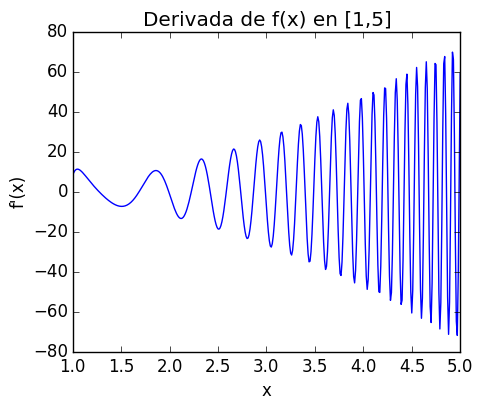

PyObject <matplotlib.text.Text object at 0x7fab5abcc438>

In [8]:
figure(figsize=(5,4))
plot(dom, ran)
xlabel("x")
ylabel("f'(x)")
title("Derivada de f(x) en [1,5]")

# Ejercicio

Implementen el método de Newton para una función arbitraria $f(x)$ en una variable (la función `newton1D` debe tener un argumento que es una función) a fin de encontrar un cero de la función, i.e., $f(x^*)=0$. El método de Newton requiere la derivada evaluada en diversos puntos, cosa que obtendrán usando el módulo de derivación automática.

- Obtengan, usando su función del método de Newton, las raices del polinomio de Wilkinson $W_{6}(x)$, usando como iterados iniciales $x_0=2.2$ y $x_0=2.45$.
    
- Hagan lo mismo que en el inciso anterior para $g(x) = x \sin(2x)$, con $x_0=0.7$.

In [9]:
#Implementaremos el método de Newton, para hallar un cero de una función arbitraria, según nosotros, se necesita
#por lo menos una adivinanza para iterar a partir de ella. Así que la función newton1D tendrá dos argumentos, la
#función y la adivinanza, que por defecto tendrá valor del dual (1,1)
function newton1D{T<:Real}(f::Function, x::T)
    x_0 = xdual(x)
    approx = f(x_0)
    approx_c = x_0.fun - approx.fun/approx.der
    if abs(f(approx_c)⋅f(approx_c)) > 1e-20
        newton1D(f, approx_c)
    else 
        return approx_c
    end
end   

#Ahora, nos robaremos el código de Luis para crear los polinomios de Wilkinson
nombre(n::Int) = symbol( string("W_", n) )
function wilkinson(n::Int)
    # Checo que `n` sea >= 1
    @assert n >= 1
    
    ex = :(x-1)
    for i = 2:n
        ex = :( ($ex) * ( x-$i) )
    end
    ex_ret = :( $(nombre(n))(x) = $ex )
    ex_ret
end

#Creamos el polinomio W_6
eval(wilkinson(6))

W_6 (generic function with 1 method)

In [10]:
#Ahora buscaremos un cero W_6 usando las adivinanzas iniciales solicitadas, primero con x_0 = 2.2
newton1D(W_6, 2.2)

2.0

In [11]:
#Ahora con x_0 = 2.45
newton1D(W_6, 2.45)

6.000000000000067

**Nota:**

En ambos casos se obtuvo una raíz de la función de Wilkinson (que sabemos que son 1, 2, 3, 4, 5 y 6), extraña un poco que para 2.45 se obtuviera como raíz a 6, adicionalmente, graficaremos el cero que encuentra la función `newton1D` a partir de una adivinanza dada.

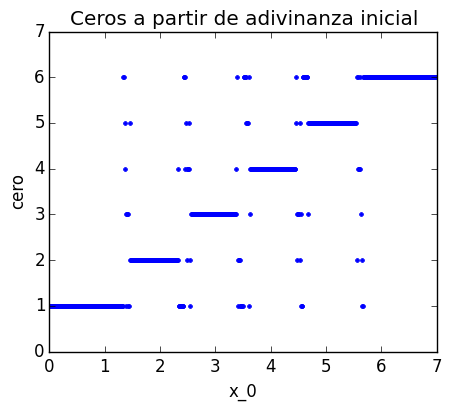

PyObject <matplotlib.text.Text object at 0x7fab58631f60>

In [12]:
adiv = collect(0:0.01:7)
ran2 = Float64[newton1D(W_6, x) for x in adiv];


figure(figsize=(5,4))
plot(adiv, ran2, linestyle="", marker =".")
xlabel("x_0")
ylabel("cero")
title("Ceros a partir de adivinanza inicial")

In [13]:
#Ahora para la función g(x)
g(x) = x*sin(2x)
newton1D(g, 0.7) #Tenemos que con este valor, calcula al cero como x = 0

4.086255907155701e-6

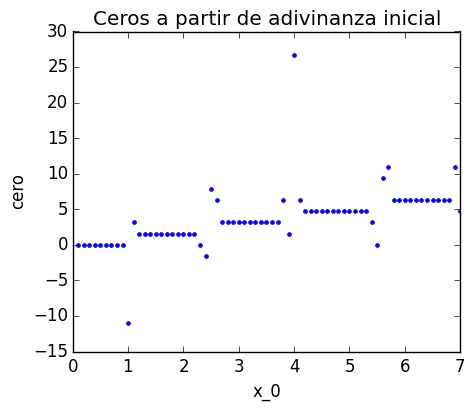

PyObject <matplotlib.text.Text object at 0x7fab58619a20>

In [14]:
adiv2 = collect(0:0.1:7)
ran3 = Float64[newton1D(g, x) for x in adiv2];


figure(figsize=(5,4))
plot(adiv2, ran3, linestyle="", marker =".")
xlabel("x_0")
ylabel("cero")
title("Ceros a partir de adivinanza inicial")

# Pregunta

¿Qué hacer si se requieren derivadas de orden superior, es decir, la segunda, tercera, etc, derivada? Argumenten.

**NOTA:** Esta pregunta debe ser contestada pero **no** será considerada para aceptar la tarea; la idea es empezar a pensar en esto.

#### Una posible salida: 

Tal vez lo más ingenuo es hacer que aparezca la $n-$ésima derivada y las anteriores a ella agregando más entradas a nuestro vector $\vec{v}$ de la siguiente forma:

$$ \vec{f} = f + \displaystyle \sum_{j=1}^{n}f^{(j)}\hat{\mathbf{h}}_j$$

Claro, imponiendo condiciones sobre la multiplicación que más o menos pueden intuirse como:

$\hat{\mathbf{h}}_i \cdot \hat{\mathbf{h}}_j = 0$ si $i+j>n$

$\hat{\mathbf{h}}_i \cdot \hat{\mathbf{h}}_j = c(i,j)\hat{\mathbf{h}}_{i+j}$ si $i+j \leq n$

Además podríamos decir que los coeficientes $c(i,j)$ deben estar en terminos de $C_i^j$ (combinaciones de $j$ en $k$) porque queremos que la multiplicación de dos duales $\vec{u}$ y $\vec{v}$ ($\vec{u}\times\vec{v}$) cumplan con la regla generalizada de Leibniz dada por:

$$(fg)^{(n)} = \displaystyle \sum_{j=0}^n \binom{n}{j}f^{(j)}g^{(n-j)}$$

#### Una salida hipotética y más rebuscada:

Tomarnos más tiempo para redefinir el concepto de "Dual". Si consiguiéramos que esta función nos dejase poner las derivadas y las funciones en términos de símbolos, podríamos redefinir las operaciones para que funcionaran de manera "simbólica". Es decir... si ```xdual()``` --> ```(:x, 1)```, definir operaciones apropiadas para ```*, +, -, ^```, etc. Esto para que el hecho de *derivar* con duales sea recursivo y obtener algo del tipo...
```julia
r = xdual()
f'(x) = f(r).der
f''(x) = f'(r).der

```

...o algo así.

También podríamos optimizar la definión del vector de pares función-derivada utilizando metraprogramming.